<a href="https://colab.research.google.com/github/GruAna/VU/blob/master/m_tesseract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tesseract

## Packages

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install imgaug==0.2.6
!pip install --ignore-installed Pillow==9.0.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 19 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 3s (1,445 kB/s)
debconf: unable to initi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 631 kB 4.3 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654017 sha256=08500a65de30acdb9cf1a252fa4eebf195690854eb237ad84eb375875dedf95a
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.4.0
    Uninstalling imgaug-0.4.0:
      Successfully uninstalled imgaug-0.4.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.3 MB 4.2 MB/s 


In [ ]:
import pytesseract
from pytesseract import Output
import os
import cv2 as cv
import numpy as np
import pandas as pd

from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp drive/MyDrive/Colab_Notebooks/VU/utils.py .
from utils import *

## Setup

## Dataset loading

### CTW1500 dataset

 - testing set (500 images)

Get images. Update location of images **manually**.

Comment if not using CTW1500 dataset.

In [ ]:
# whether images are to be resized (skrinking)
resize = False
width = 3000

# path to image directory, get full path to all files
imgs_dir = '/content/drive/MyDrive/Colab_Notebooks/VU/CTW1500/test_images'

(_, _, filenames) = next(os.walk(imgs_dir))
filenames.sort()
list_img_paths = [os.path.join(imgs_dir, file) for file in filenames][:10]
n_imgs = len(list_img_paths)

# load images
original_images = [(cv.imread(file)) for file in list_img_paths]
                        
# shrink images
if resize:
    images = shrink_all(original_images, width)
else:
    images = original_images.copy()

# grayscale
images = [cv.cvtColor(img, cv.COLOR_BGR2GRAY) for img in images]

# # threshold
patches = [(img.shape[0] // 16) * 2 + 1 for img in images]
images = [cv.adaptiveThreshold(images[i], 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, patches[i], 5) for i in range(n_imgs)]
# # # closing 
# kernel = cv.getStructuringElement(cv.MORPH_CROSS,(3,3))
# images = [cv.morphologyEx(img, cv.MORPH_CLOSE, kernel) for img in images]    

# Get paths to files with labels. Update location manually
# path to label directory, get full path to all files
labels_dir = '/content/drive/MyDrive/Colab_Notebooks/VU/CTW1500/test_labels'
(_, _, xml_files) = next(os.walk(labels_dir))
xml_files.sort()
list_xml_paths = [os.path.join(labels_dir, file) for file in xml_files]

# Get ground truths from all xml files
ground_truth = []

# if images where resized we need to resize also the coordinates in gt
if resize:
    for i, file in enumerate(list_xml_paths):
        ratio = width / original_images[i].shape[1]
        if ratio > 1:
            ratio = 1
        ground_truth.append(read_gt_ctw_test(file, scaling_ratio=ratio))
else:
    for i, file in enumerate(list_xml_paths):
        ground_truth.append(read_gt_ctw_test(file))

# ground_truth is in the is a list of tuples, where first is the gt word 
# and second is an array of top left and bottom right coordinates
# format: ('text', [[tl,tl],[br,br]])

### KAISTdetectiondataset

In [ ]:
# path to image and label directory, get full path to all files
directory = '/content/drive/MyDrive/Colab_Notebooks/VU/Kaist'

list_img_paths = []
list_bmp_paths = []
list_xml_paths = []
filenames = []
for path, dirs, files in os.walk(directory):
    for file in files:
        if(file.endswith(".jpg") or file.endswith(".JPG") ):
            list_img_paths.append(os.path.join(path, file))
            filenames.append(file)
        if(file.endswith(".bmp")):
            list_bmp_paths.append(os.path.join(path, file))
        if(file.endswith(".xml")):
            list_xml_paths.append(os.path.join(path, file))

list_xml_paths.sort()
list_bmp_paths.sort()
list_img_paths.sort()

n_imgs = len(list_img_paths)
n_bmps = len(list_bmp_paths)
n_labels = len(list_xml_paths)

assert n_imgs == n_labels, "Check both xml and image files"

# whether images are to be resized (skrinking)
resize = False
width = 3000

# load images
original_images = [(cv.imread(file)) for file in list_img_paths]
# load images = bmp images (detected text)
# from already text detected images, which are provided in Kaist dataset
# original_images = [(cv.imread(file)) for file in list_bmp_paths]
  
# shrink images
if resize:
    images = shrink_all(original_images, width)
else:
    images = original_images.copy()

# grayscale
# images = [cv.cvtColor(img, cv.COLOR_BGR2GRAY) for img in images]

# threshold
# patches = [(img.shape[0] // 16) * 2 + 1 for img in images]
# images = [cv.adaptiveThreshold(images[i], 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, patches[i], 5) for i in range(n_imgs)]


# Get ground truths from all xml files
ground_truth = []

# if images where resized we need to resize also the coordinates in gt
if resize:
    for i, file in tqdm(enumerate(list_xml_paths)):
        ratio = width / original_images[i].shape[1]
        if ratio > 1:
            ratio = 1
        ground_truth.append(read_gt_kaist(file, scaling_ratio=ratio))
else:
    for i, file in tqdm(enumerate(list_xml_paths)):
        ground_truth.append(read_gt_kaist(file))

# ground_truth is in the is a list of tuples, where first is the gt word 
# and second is an array of top left and bottom right coordinates
# format: ('text', [[tl,tl],[br,br]])

395it [00:00, 685.24it/s]


## Born digital dataset

In [ ]:
# path to image and label directory, get full path to all files
imgs_dir = '/content/drive/MyDrive/Colab_Notebooks/VU/BD/Challenge1_Training_Task12_Images'
labels_dir = '/content/drive/MyDrive/Colab_Notebooks/VU/BD/ch1_training_localization_transcription_gt'

(_, _, filenames) = next(os.walk(imgs_dir))
filenames.sort()
list_img_paths = [os.path.join(imgs_dir, file) for file in filenames]

(_, _, txt_files) = next(os.walk(labels_dir))
txt_files.sort()
list_txt_paths = [os.path.join(labels_dir, file) for file in txt_files]

n_imgs = len(list_img_paths)
n_labels = len(list_txt_paths)

assert n_imgs == n_labels, "Check both ground truth and image files"

# whether images are to be resized (skrinking)
resize = False
width = 3000

# load images
original_images = [(cv.imread(file)) for file in list_img_paths]
# load images = bmp images (detected text)
# from already text detected images, which are provided in Kaist dataset
# original_images = [(cv.imread(file)) for file in list_bmp_paths]
  
# shrink images
if resize:
    images = shrink_all(original_images, width)
else:
    images = original_images.copy()

# grayscale
# images = [cv.cvtColor(img, cv.COLOR_BGR2GRAY) for img in images]

# threshold
# patches = [(img.shape[0] // 16) * 2 + 1 for img in images]
# images = [cv.adaptiveThreshold(images[i], 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, patches[i], 5) for i in range(n_imgs)]


# Get ground truths from all xml files
ground_truth = []

# if images where resized we need to resize also the coordinates in gt
if resize:
    for i, file in tqdm(enumerate(list_xml_paths)):
        ratio = width / original_images[i].shape[1]
        if ratio > 1:
            ratio = 1
        ground_truth.append(read_gt_bd(file, scaling_ratio=ratio))
else:
    for i, file in tqdm(enumerate(list_txt_paths)):
        ground_truth.append(read_gt_bd(file))

# ground_truth is in the is a list of tuples, where first is the gt word 
# and second is an array of top left and bottom right coordinates
# format: ('text', [[tl,tl],[br,br]])

25it [00:00, 245.49it/s]

['178', '11', '209', '11', '209', '25', '178', '25', 'flying']
['215', '11', '249', '11', '249', '24', '215', '24', 'today']
['256', '14', '297', '14', '297', '22', '256', '22', 'means']
['317', '7', '379', '7', '379', '28', '317', '28', 'vueling']
['61', '64', '91', '64', '91', '76', '61', '76', 'GET']
['97', '64', '150', '64', '150', '79', '97', '79', 'AWAY', '']
['61', '82', '146', '82', '146', '95', '61', '95', '1.000.000']
['61', '101', '108', '101', '108', '113', '61', '113', 'SEATS']
['62', '119', '108', '119', '108', '132', '62', '132', 'FROM']
['62', '140', '149', '140', '149', '174', '62', '174', '30€']
['322', '413', '349', '413', '349', '421', '322', '421', 'Book']
['354', '413', '380', '413', '380', '421', '354', '421', 'now!']
['33', '10', '217', '10', '217', '57', '33', '57', 'FORUMS']
['87', '95', '168', '95', '168', '122', '87', '122', 'ENTER']
['132', '162', '222', '162', '222', '186', '132', '186', 'Windows']
['227', '156', '237', '156', '237', '172', '227', '172', '

72it [00:00, 170.62it/s]

['4', '9', '260', '9', '260', '97', '4', '97', 'Google']
['263', '30', '272', '30', '272', '34', '263', '34', '###']
['11', '12', '23', '12', '23', '31', '11', '31', '###']
['33', '11', '66', '11', '66', '31', '33', '31', 'for']
['76', '12', '88', '12', '88', '31', '76', '31', '###']
['10', '10', '64', '10', '64', '29', '10', '29', 'New']
['7', '6', '41', '6', '41', '22', '7', '22', 'Web']
['42', '6', '76', '6', '76', '21', '42', '21', '###']
['6', '28', '79', '28', '79', '44', '6', '44', 'Symptom']
['86', '27', '145', '27', '145', '40', '86', '40', 'checker']
['7', '292', '36', '292', '36', '303', '7', '303', 'Click']
['42', '292', '70', '292', '70', '303', '42', '303', 'here']
['75', '293', '86', '293', '86', '303', '75', '303', '###']
['92', '293', '112', '293', '112', '306', '92', '306', 'get']
['118', '292', '162', '292', '162', '303', '118', '303', 'started']
['40', '317', '65', '317', '65', '329', '40', '329', 'Web']
['67', '317', '92', '317', '92', '328', '67', '328', '###']
['

90it [00:00, 164.53it/s]

['107', '22', '113', '22', '113', '29', '107', '29', '###']
['121', '19', '166', '19', '166', '32', '121', '32', 'laptop']
['173', '19', '192', '19', '192', '29', '173', '29', 'for']
['199', '19', '235', '19', '235', '29', '199', '29', 'them']
['107', '40', '125', '40', '125', '48', '107', '48', 'and']
['130', '42', '135', '42', '135', '48', '130', '48', '###']
['140', '40', '173', '40', '173', '50', '140', '50', 'dongle']
['178', '40', '191', '40', '191', '48', '178', '48', 'for']
['195', '42', '212', '42', '212', '50', '195', '50', 'you']
['107', '56', '129', '56', '129', '64', '107', '64', 'from']
['133', '56', '150', '56', '150', '66', '133', '66', 'just']
['156', '56', '184', '56', '184', '64', '156', '64', '£4.89']
['189', '58', '193', '58', '193', '64', '189', '64', '###']
['198', '56', '230', '56', '230', '64', '198', '64', 'month']
['6', '113', '101', '113', '101', '157', '6', '157', '£4.89']
['9', '35', '57', '35', '57', '50', '9', '50', 'Abbey']
['60', '35', '96', '35', '96'

124it [00:00, 157.56it/s]

['77', '60', '99', '60', '99', '74', '77', '74', 'RAF']
['148', '166', '189', '166', '189', '171', '148', '171', 'museum']
['62', '10', '126', '10', '126', '19', '62', '19', 'NATIONAL']
['67', '41', '117', '41', '117', '54', '67', '54', 'COLD']
['62', '58', '122', '58', '122', '71', '62', '71', 'WAR']
['61', '94', '128', '94', '128', '103', '61', '103', 'EXHIBITION']
['51', '39', '71', '39', '71', '63', '51', '63', 'RAF']
['83', '33', '129', '33', '129', '64', '83', '64', 'STATION']
['46', '69', '58', '69', '58', '80', '46', '80', '###']
['121', '70', '135', '70', '135', '81', '121', '81', '###']
['53', '89', '127', '89', '127', '116', '53', '116', 'HELIOPOLIS']
['64', '120', '117', '120', '117', '132', '64', '132', '###']
['65', '125', '116', '125', '116', '150', '65', '150', 'MERRY']
['69', '139', '120', '139', '120', '165', '69', '165', 'XMAS']
['74', '166', '88', '166', '88', '181', '74', '181', '###']
['94', '158', '119', '158', '119', '175', '94', '175', 'all']
['146', '228', '18

161it [00:00, 167.13it/s]

['6', '25', '58', '25', '58', '33', '6', '33', 'LATEST']
['5', '38', '59', '38', '59', '48', '5', '48', 'NEWS...']
['98', '8', '143', '8', '143', '17', '98', '17', 'AERO']
['193', '7', '215', '7', '215', '15', '193', '15', '4/4']
['222', '8', '247', '8', '247', '16', '222', '16', 'and']
['256', '8', '275', '8', '275', '15', '256', '15', '###']
['306', '7', '395', '7', '395', '16', '306', '16', 'ROADSTER']
['425', '8', '433', '8', '433', '16', '425', '16', '###']
['440', '7', '502', '7', '502', '16', '440', '16', 'SEATER']
['558', '7', '603', '7', '603', '15', '558', '15', 'AERO']
['657', '7', '737', '7', '737', '15', '657', '15', 'AEROMAX']
['776', '7', '808', '7', '808', '15', '776', '15', 'LIFE']
['815', '7', '846', '7', '846', '16', '815', '16', 'CAR']
['877', '7', '976', '7', '976', '16', '877', '16', 'SUPERSPORT']
['70', '32', '116', '32', '116', '43', '70', '43', 'SUPER']
['119', '32', '171', '32', '171', '43', '119', '43', 'SPORTS']
['141', '74', '182', '74', '182', '97', '141',

197it [00:01, 165.60it/s]

['7', '75', '31', '75', '31', '83', '7', '83', 'New']
['7', '85', '34', '85', '34', '93', '7', '93', '2009']
['40', '85', '69', '85', '69', '93', '40', '93', 'FALL']
['74', '85', '77', '85', '77', '93', '74', '93', '###']
['82', '85', '131', '85', '131', '93', '82', '93', 'WINTER']
['7', '95', '87', '95', '87', '103', '7', '103', 'COLLECTION']
['19', '13', '67', '13', '67', '22', '19', '22', 'YOU.']
['70', '13', '196', '13', '196', '22', '70', '22', 'AUTOMATIC']
['131', '13', '178', '13', '178', '34', '131', '34', 'CreArt']
['142', '37', '188', '37', '188', '48', '142', '48', 'swatch']
['16', '7', '78', '7', '78', '48', '16', '48', 'Street']
['24', '39', '84', '39', '84', '66', '24', '66', '"CLuB"']
['15', '70', '29', '70', '29', '77', '15', '77', "It's"]
['35', '73', '57', '73', '57', '77', '35', '77', 'more']
['62', '70', '82', '70', '82', '77', '62', '77', 'than']
['88', '73', '91', '73', '91', '77', '88', '77', '###']
['97', '70', '126', '70', '126', '78', '97', '78', 'watch', '']


214it [00:01, 139.47it/s]

['206', '26', '330', '26', '330', '34', '206', '34', 'KANSAS']
['367', '26', '438', '26', '438', '34', '367', '34', 'CITY']
['187', '45', '444', '45', '444', '103', '187', '103', 'CHIEFS']
['110', '45', '214', '45', '214', '112', '110', '112', '###']
['8', '12', '72', '12', '72', '24', '8', '24', 'SPECIAL']
['79', '13', '138', '13', '138', '24', '79', '24', 'OFFERS']
['145', '13', '176', '13', '176', '24', '145', '24', 'AND']
['184', '13', '228', '13', '228', '24', '184', '24', 'NEWS']
['9', '30', '50', '30', '50', '42', '9', '42', 'FROM']
['58', '30', '87', '30', '87', '42', '58', '42', 'THE']
['94', '30', '149', '30', '149', '42', '94', '42', 'CHIEFS']
['11', '12', '79', '12', '79', '23', '11', '23', 'SPONSORED']
['13', '31', '81', '31', '81', '57', '13', '57', 'FREE']
['94', '31', '232', '31', '232', '57', '94', '57', 'WEBINAR']
['147', '107', '197', '107', '197', '116', '147', '116', 'Advanced']
['201', '107', '230', '107', '230', '118', '201', '118', 'Agile:']
['76', '119', '114',

243it [00:01, 115.53it/s]

['453', '17', '487', '17', '487', '28', '453', '28', 'From']
['493', '17', '523', '17', '523', '31', '493', '31', 'only']
['455', '34', '613', '34', '613', '101', '455', '101', '£10']
['562', '106', '584', '106', '584', '117', '562', '117', 'Per']
['588', '106', '613', '106', '613', '120', '588', '120', 'day']
['464', '229', '533', '229', '533', '252', '464', '252', 'Book']
['543', '230', '604', '230', '604', '252', '543', '252', 'Now']
['13', '33', '81', '33', '81', '86', '13', '86', 'NOW']
['90', '8', '133', '8', '133', '43', '90', '43', '###']
['125', '70', '234', '70', '234', '101', '125', '101', 'HALF']
['102', '122', '233', '122', '233', '153', '102', '153', 'PRICE']
['253', '69', '547', '69', '547', '157', '253', '157', 'SALE']
['527', '188', '557', '188', '557', '208', '527', '208', 'Sale']
['562', '169', '594', '169', '594', '190', '562', '190', 'ends']
['597', '149', '627', '149', '627', '171', '597', '171', '21st']
['632', '136', '659', '136', '659', '154', '632', '154', 'Ja

280it [00:01, 140.21it/s]

['54', '62', '85', '62', '85', '83', '54', '83', '###']
['94', '62', '134', '62', '134', '83', '94', '83', 'and']
['146', '62', '182', '62', '182', '83', '146', '83', 'ROI']
['50', '93', '112', '93', '112', '105', '50', '105', 'Collection']
['118', '92', '127', '92', '127', '105', '118', '105', '###']
['133', '93', '184', '93', '184', '108', '133', '108', 'Delivery']
['154', '44', '357', '44', '357', '88', '154', '88', 'Currents']
['287', '83', '414', '83', '414', '121', '287', '121', 'Monthly']
['630', '90', '686', '90', '686', '100', '630', '100', 'ANALOG']
['630', '103', '687', '103', '687', '113', '630', '113', 'DEVICES']
['248', '41', '339', '41', '339', '59', '248', '59', 'FREE']
['246', '67', '384', '67', '384', '85', '246', '85', 'ONLINE']
['395', '67', '584', '67', '584', '85', '395', '85', 'TUTORIAL']
['64', '86', '216', '86', '216', '110', '64', '110', 'Tutorials']
['248', '92', '293', '92', '293', '103', '248', '103', 'from']
['300', '91', '340', '91', '340', '103', '300', 

312it [00:02, 147.46it/s]

['63', '14', '100', '14', '100', '27', '63', '27', 'ACER']
['104', '14', '156', '14', '156', '27', '104', '27', 'ASPIRE']
['161', '15', '196', '15', '196', '27', '161', '27', '5742']
['143', '58', '163', '58', '163', '65', '143', '65', 'Intel']
['168', '57', '189', '57', '189', '65', '168', '65', 'Core']
['194', '57', '234', '57', '234', '65', '194', '65', 'i3-370M']
['143', '72', '160', '72', '160', '79', '143', '79', '4GB']
['167', '72', '186', '72', '186', '79', '167', '79', 'RAM']
['143', '85', '173', '85', '173', '93', '143', '93', '320GB']
['179', '86', '200', '86', '200', '93', '179', '93', 'Hard']
['205', '85', '229', '85', '229', '93', '205', '93', 'Drive']
['144', '101', '168', '101', '168', '108', '144', '108', '15.6"']
['174', '100', '205', '100', '205', '108', '174', '108', 'Screen']
['144', '115', '161', '115', '161', '122', '144', '122', 'DVD']
['166', '114', '193', '114', '193', '124', '166', '124', 'Super']
['195', '119', '197', '119', '197', '119', '195', '119', '###'

328it [00:02, 127.60it/s]

['233', '20', '513', '20', '513', '50', '233', '50', 'stayAmsterdam.com']
['38', '176', '93', '176', '93', '188', '38', '188', 'Studios']
['99', '176', '134', '176', '134', '188', '99', '188', 'from']
['141', '176', '170', '176', '170', '188', '141', '188', '€59']
['177', '179', '202', '179', '202', '192', '177', '192', 'per']
['208', '176', '247', '176', '247', '192', '208', '192', 'night']
['253', '179', '292', '179', '292', '191', '253', '191', '(sleeps']
['298', '179', '307', '179', '307', '190', '298', '190', '###']
['37', '198', '57', '198', '57', '213', '37', '213', '###']
['64', '198', '78', '198', '78', '209', '64', '209', '###']
['84', '197', '115', '197', '115', '209', '84', '209', '35%']
['123', '197', '194', '197', '194', '209', '123', '209', 'discounts']
['201', '200', '219', '200', '219', '209', '201', '209', '###']
['226', '198', '264', '198', '264', '213', '226', '213', 'stays']
['271', '197', '282', '197', '282', '209', '271', '209', '###']
['289', '198', '315', '198'

355it [00:02, 120.80it/s]


['17', '41', '267', '41', '267', '66', '17', '66', 'RESEARCHERID']
['281', '41', '374', '41', '374', '67', '281', '67', 'NEWS']
['21', '27', '46', '27', '46', '58', '21', '58', '###']
['53', '27', '145', '27', '145', '64', '53', '64', 'Depth']
['320', '18', '343', '18', '343', '25', '320', '25', 'JULY']
['348', '18', '372', '18', '372', '25', '348', '25', '2010']
['19', '77', '29', '77', '29', '90', '19', '90', '###']
['38', '77', '159', '77', '159', '91', '38', '91', 'ResearcherID']
['168', '77', '264', '77', '264', '90', '168', '90', 'Newsletter']
['14', '18', '52', '18', '52', '29', '14', '29', 'Learn']
['59', '18', '87', '18', '87', '28', '59', '28', 'how']
['93', '18', '154', '18', '154', '28', '93', '28', 'EndNote']
['159', '18', '190', '18', '190', '28', '159', '28', 'Web']
['14', '37', '38', '37', '38', '45', '14', '45', 'can']
['44', '35', '73', '35', '73', '48', '44', '48', 'help']
['78', '38', '102', '38', '102', '48', '78', '48', 'you']
['109', '37', '165', '37', '165', '4

382it [00:02, 114.51it/s]

['16', '41', '312', '41', '312', '63', '16', '63', 'DISCOVERIRELAND.IE']
['16', '70', '50', '70', '50', '77', '16', '77', 'RIGHT']
['54', '70', '85', '70', '85', '78', '54', '78', 'HERE', '']
['88', '70', '122', '70', '122', '78', '88', '78', 'RIGHT']
['126', '70', '153', '70', '153', '77', '126', '77', 'NOW']
['15', '93', '27', '93', '27', '101', '15', '101', '###']
['32', '93', '83', '93', '83', '101', '32', '101', 'Consumer']
['11', '105', '51', '105', '51', '116', '11', '116', 'Support']
['56', '105', '85', '105', '85', '113', '56', '113', 'Forum']
['21', '93', '27', '93', '27', '101', '21', '101', '###']
['33', '93', '76', '93', '76', '101', '33', '101', 'Resource']
['15', '105', '47', '105', '47', '113', '15', '113', 'Center']
['53', '105', '81', '105', '81', '113', '53', '113', 'Forum']
['19', '93', '59', '93', '59', '101', '19', '101', 'VooDoo']
['65', '93', '77', '93', '77', '101', '65', '101', '###']
['10', '105', '50', '105', '50', '116', '10', '116', 'Gaming']
['57', '105',

410it [00:02, 141.31it/s]

['33', '15', '173', '15', '173', '67', '33', '67', 'build']
['192', '30', '319', '30', '319', '82', '192', '82', 'your']
['335', '30', '514', '30', '514', '67', '335', '67', 'career']
['33', '74', '50', '74', '50', '90', '33', '90', '###']
['62', '74', '186', '74', '186', '91', '62', '91', 'COMPUTING']
['523', '67', '561', '67', '561', '84', '523', '84', 'Our']
['570', '68', '656', '68', '656', '89', '570', '89', 'experts.']
['530', '93', '577', '93', '577', '109', '530', '109', 'Your']
['586', '93', '655', '93', '655', '109', '586', '109', 'future.']
['35', '14', '239', '14', '239', '32', '35', '32', 'careers.computer.org']
['10', '53', '116', '53', '116', '67', '10', '67', 'EMPLOYERS']
['10', '76', '53', '76', '53', '85', '10', '85', 'REACH']
['60', '76', '95', '76', '95', '85', '60', '85', 'OVER']
['101', '76', '149', '76', '149', '87', '101', '87', '125', '000']
['9', '92', '81', '92', '81', '101', '9', '101', 'COMPUTER']
['10', '108', '113', '108', '113', '117', '10', '117', 'PROF

## Vienna City Poster dataset

In [ ]:
# path to image and label directory, get full path to all files
# original size of images, shrinked images
imgs_dir = '/content/drive/MyDrive/Colab_Notebooks/VU/alljpg'
labels_dir = '/content/drive/MyDrive/Colab_Notebooks/VU/allxml'

(_, _, filenames) = next(os.walk(imgs_dir))
filenames.sort()
list_img_paths = [os.path.join(imgs_dir, file) for file in filenames[123:]]

(_, _, xml_files) = next(os.walk(labels_dir))
xml_files.sort()
list_xml_paths = [os.path.join(labels_dir, file) for file in xml_files[123:]]

n_imgs = len(list_img_paths)
n_labels = len(list_xml_paths)
assert n_imgs == n_labels, "Check both xml and image files"

# whether images are to be resized (skrinking)
resize = False
# whether image WERE resized (small images are loaded from directory)
resized = False
# width of scaled images
width = 1000


# load images
images = [(cv.imread(file)) for file in list_img_paths]
  
# shrink images
if resize:
    images = shrink_all(images, width)

# Get ground truths from all xml files
ground_truth = []

# if images where resized we need to resize also the coordinates in gt
if resize:
    for i, file in tqdm(enumerate(list_xml_paths)):
        ratio = width / images[i].shape[1]
        if ratio > 1:
            ratio = 1
        ground_truth.append(read_gt_wien(file, scaling_ratio=ratio))
elif resized:
    for i, file in tqdm(enumerate(list_xml_paths)):
        ground_truth.append(read_gt_wien(file, scaling_ratio=width, resized_previously=resized))
else:
    for i, file in tqdm(enumerate(list_xml_paths)):
        ground_truth.append(read_gt_wien(file))

# ground_truth is in the is a list of tuples, where first is the gt word 
# and second is an array of top left and bottom right coordinates
# format: ('text', [[tl,tl],[br,br]])

134it [00:30,  4.41it/s]


## Prediction

Run OCR method.

In [ ]:
# loop through all images in image directory

predictions = []
custom_config = r'--oem 3 --psm 6'

for img in tqdm(images):
    output = pytesseract.image_to_data(img, output_type=Output.DICT, config=custom_config)

    predictions.append(output)

100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


## Results postprocessing

### Metrics
Compare bounding boxes of predicition and ground truth.

Count Intersection over Union (IoU) metric for bounding boxes. Store for all images in a list `iou_images`. (detection)

Count Character Error Rate (CER) metric for characters in words. Store for all images in a list `cer_images`. (recognition)

Then store average IOU and CER for each image in `iou_in_image` and `cer_in_image`.

In [ ]:
# -------------------------- Bounding boxes --------------------------
# Calculate bounding rectangles for detected words in an image. 
# Replace polygon coordinates by these two rectangle coordinates.
# In case of german language, argument of get_predicted: correctgerman=True (default False)
predicted = get_predicted_tesseract(predictions, correctgerman=False)

# Specify parameters for evaluation
split = False
special_chars = True
case_sensitivity = True

# -------------------------- Metrics --------------------------
# iou_images, cer_images - a list containing pairs of text from predicted and 
# ground truth strings and a metric value for the pair (= tuple of three). 
# It is a list of lists (Outer list for images, inner list for text regions in one image)
iou_images, cer_images = get_iou_cer(ground_truth, predicted, special_chars=special_chars, 
                                     case_sensitivity=case_sensitivity, split=split)

# iou_in_image, cer_in_image - a list containing an average value of respective metric 
# throughout all text regions in an image for all images, the length is equal to the number of images 
iou_in_image, cer_in_image = get_iou_cer_average(iou_images, cer_images)

### Metrics
Metrics for each image (average of values of all regions in one image).

IoU (detection) `iou_in_image`

CER (recognition) `cer_in_image`

Compare bounding boxes of predicition and ground truth.

Count Intersection over Union (IoU) metric for bounding boxes. Store for all images in a list `iou_images`.

Count Character Error Rate (CER) metric for characters in words. Store for all images in a list `cer_images`.

In [ ]:
iou_images = []
cer_images = []

# loop through images:
for i in range(n_imgs):
    if not predicted[i] and len(ground_truth[i]): 
        iou_images.append([(0, -1)])
        cer_images.append([[('', '', 1)]])
        continue
    elif len(ground_truth[i]):
        predicted_cols = list(zip(*predicted[i]))
    else:
        iou_images.append(None)
        cer_images.append(None)
        continue

    ground_truth_cols = list(zip(*ground_truth[i]))

    # take only coordinate arrays from list for each images
    pred_boxes = predicted_cols[1]
    gt_boxes = ground_truth_cols[1]
    iou_from_image = iou_image(pred_boxes, gt_boxes)

    iou_text_regions = group_text(iou_from_image)

    # take only labels for each image
    pred_labels = predicted_cols[0]
    gt_labels = ground_truth_cols[0]

    # compare corresponding labels
    # comparision is a list of all text regions on one image
    comparision = []
    for gt_ind, observation in enumerate(iou_text_regions):
        pred_ind = observation[1]
        predicted_text = " ".join([pred_labels[i] for i in pred_ind])
        gt_pred_text = (gt_labels[gt_ind], predicted_text)

        # comparision for one text region (on one image)
        comparision.append((compare_text_cer(gt_pred_text, special_characters=False, case_sensitive=False, split=False)))

    iou_images.append((iou_text_regions))
    cer_images.append((comparision))

In [ ]:
iou_in_image = []
cer_in_image = []

for i in range(n_imgs):
    if isinstance(cer_images[i], list):
        length = len(cer_images[i])
        mean_in_regions = average([average(list(zip(*cer_images[i][j]))[2]) for j in range(length) ])
        iou_in_image.append(average(list(zip(*iou_images[i]))[0]))
    else:
        mean_in_regions = None
        iou_in_image.append(None)
      
    cer_in_image.append(mean_in_regions)

### Overall results for dataset

Specify unique filename and specification.

Specification is an array of first used method, second some useful infromation.

In [ ]:
# SELECT FROM OPTIONS BELOW OR CREATE YOUR OWN, COMMENT UNUSED:

# basic tesseract (original image size, case insensitive, only alphanumeric)
# file_name = "tesseract_CTWtest_u_split_BW"
# specifications = ["tesseract untrained", "dataset: CTW1500", "original image size, case insensitive, only alphanumeric, split"]

file_name = "tesseract_Kaist_u_nosplit_6_color"
specifications = ["tesseract untrained", "dataset: Kaist", "colored, original image size, case insensitive, only alphanumeric, no split, psm6"]

# file_name = "tesseract_Kaist_bmp_u_nosplit"
# specifications = ["tesseract untrained", "dataset: Kaist bmp", "original image size, case insensitive, only alphanumeric, no split"]

# file_name = "tesseract_BD_u_nosplit_11_color"
# specifications = ["tesseract untrained", "dataset: Born-Digital", "colored, original image size, case insensitive, only alphanumeric, nosplit, psm11"]


In [ ]:
df_results = pd.DataFrame(list(zip(filenames, iou_in_image, cer_in_image)), columns =['Filename', 'IoU', 'CER'])
mean_iou = round(df_results['IoU'].mean() * 100, 1)
mean_cer = round((1 - df_results['CER'].mean()) * 100, 1)

print(file_name, ": ", specifications[-1])
print(f"mean IoU accuracy = {mean_iou}%, mean CER accuracy = {mean_cer}%")

df_results

tesseract_Kaist_u_nosplit_6_color :  colored, original image size, case insensitive, only alphanumeric, no split, psm6
mean IoU accuracy = 42.3%, mean CER accuracy = 29.6%


,Filename,IoU,CER
0,001.jpg,0.423362,1.000000
1,004.jpg,0.857876,0.454545
2,027.jpg,0.359665,1.000000
3,029.jpg,0.822625,0.375000
4,033.jpg,NaN,NaN
...,...,...,...
390,DSC02884.JPG,0.616504,1.000000
391,DSC02923.JPG,0.608163,1.000000
392,DSC02925.JPG,0.460999,0.931034
393,DSC03218.JPG,0.577464,0.777778


### Save results

In [ ]:
# set and create output directory if it doesn't exist

output_dir = 'results'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

Save to file.

In [ ]:
# create file with results (specify method and other parameters)

with open('%s/result_%s.txt' % (output_dir, file_name), 'w') as output_file:
    output_file.write(": ".join(str(text) for text in specifications))
    output_file.write("\n"+f"iou = {mean_iou}")
    output_file.write("\n"+f"cer = {mean_cer}")

Visualize bounding rectangles and corresponing words.

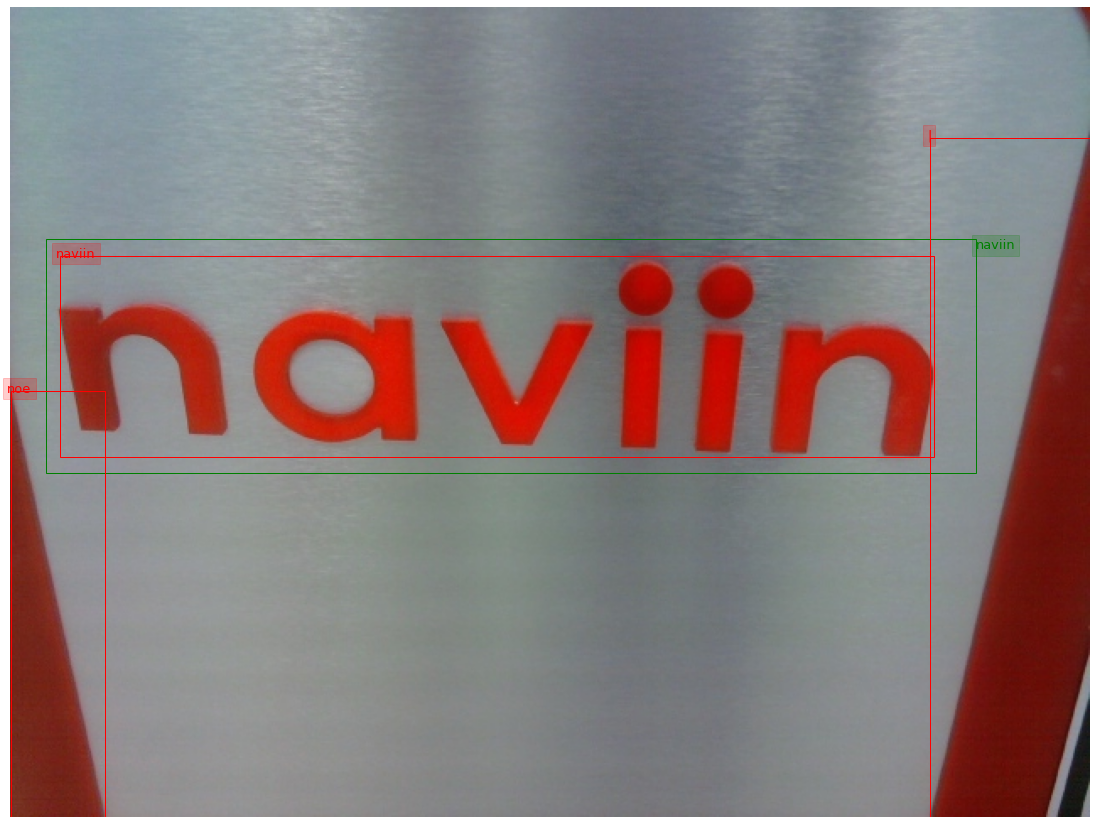

In [ ]:
# all images / one sample image
# for i in range(n_imgs):
i = 1

im = plot_results(images[i], ground_truth[i], predicted[i])  
im.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

im.savefig('%s/result_%s.png' % (output_dir, file_name))
im.show()
